# Exploratory Data Analysis & PreProcessing

## Load Packages and Libraries

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
#import json
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import statsmodels.tools.tools as stattools
import statsmodels.api as sm
from scipy import stats
from scipy.stats import mode
#import json
#!pip uninstall scikit-learn -y
#!pip install -U scikit-learn

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Perceptron
from sklearn.impute import KNNImputer
#from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn import tree

## Data Upload

In [ ]:
#credit_df.head(20)
# mount google drive for data upload
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#credit_df = pd.read_csv('MyDrive/ADS504 - Final/train.csv')
raw_df = pd.read_csv('/content/drive/MyDrive/ADS504 - Final/train.csv', header=0)
credit_df = raw_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Summary Statistics

In [ ]:
credit_df.shape

(100000, 28)

## Feature Engineering

### Convert Feature From String to Numeric

In [ ]:
# convert "credit history age" feature to years
def conv_credit_age(x):
    if pd.isnull(x):
        return x
    spt = x.split(' ')
    yr = int(spt[0].split('yr')[0])
    return (yr)

#apply the function and assign to new variable
credit_df['Credit_Age_in_Years'] = credit_df['Credit_History_Age'].apply(conv_credit_age)

# Added by Susy to have ability to impute missing values using KNNImpute later
credit_df['Credit_Age_in_Years']=pd.to_numeric(credit_df['Credit_Age_in_Years'])
                                               
#delete the previous column for Credit History Age
del credit_df['Credit_History_Age']
credit_df.head(2)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_Age_in_Years
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.82262,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,22.0
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.94496,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,NaN


#### Data Clean up

In [ ]:
# General house-cleaning:

# replace non-numeric values with null values
credit_df['Amount_invested_monthly']=pd.to_numeric(credit_df['Amount_invested_monthly'], errors='coerce')
credit_df['Monthly_Balance']=pd.to_numeric(credit_df['Monthly_Balance'], errors='coerce')

# clean invalid Credit_Mix values
credit_mix_choices = ('Good', 'Bad', 'Standard')

credit_df.loc[~credit_df['Credit_Mix'].isin(credit_mix_choices), 'Credit_Mix'] = np.nan

# convert values to category
credit_df['Credit_Mix'] = credit_df['Credit_Mix'].astype('category')



In [ ]:
credit_df.loc[~credit_df['Payment_Behaviour'].str.contains('payments'), 'Payment_Behaviour'] = np.nan
credit_df['Payment_Behaviour'] = credit_df['Payment_Behaviour'].astype('category')

# more specific to test str replacements done before:
##credit_df['Payment_Behaviour'] = credit_df['Payment_Behaviour'].replace('!@9#%8', np.NaN)	
##credit_df['Payment_Behaviour'] = credit_df['Payment_Behaviour'].astype('category')

In [ ]:
# replace invalid characters
# There are a few errors where '_' is at end or beginning of count
##credit_df['Num_of_Loan'] = credit_df['Num_of_Loan'].str.replace('_', '')	

credit_df['Num_of_Loan'] = pd.to_numeric(credit_df['Num_of_Loan'].str.replace('_', ''))
credit_df['Annual_Income'] = pd.to_numeric(credit_df['Annual_Income'].str.replace('_', ''))
credit_df['Num_of_Delayed_Payment'] = pd.to_numeric(credit_df['Num_of_Delayed_Payment'].str.replace('_', ''))
credit_df['Outstanding_Debt'] = pd.to_numeric(credit_df['Outstanding_Debt'].str.replace('_', ''))
credit_df['Age'] = pd.to_numeric(credit_df['Age'].str.replace('_', ''))

credit_df.loc[credit_df['Occupation'].str.contains('_'), 'Occupation'] = 'Other'
credit_df['Monthly_Inhand_Salary'] = pd.to_numeric(credit_df['Monthly_Inhand_Salary'])

In [ ]:
# Account for unrealistic outliers
# These are likely to be some bug in data collection

# Number of loans feature
credit_df.loc[credit_df["Num_of_Loan"] > 9, "Num_of_Loan"] = np.NaN
# Replaces negatives with 0
credit_df['Num_of_Loan'] = credit_df['Num_of_Loan'].apply(lambda x : x if x > 0 else 0)

# Age feature
credit_df.loc[credit_df["Age"] > 120, "Age"] = 0
credit_df.loc[credit_df["Age"] < 18, "Age"] = 0
credit_df['Age'] = credit_df['Age'].replace(0, np.NaN)

### Accommodating for Time Series Data

In [ ]:
# Want to take only the record that is for month August for each client
# And take the averages of all the other months for certain features
# And take the mode of certain other features as well, to impute that into the record.

# Here, we take the average for each numercial feature that makes sense 
# (We don't take average for Annual Income, Monthly Inhand Salary, 
# Num Bank Accounts Num Credit Card, Interest Rate, and Outstanding Debt,
# as these didn't change per month) by customer ID:

EMI_average =credit_df.groupby('Customer_ID')['Total_EMI_per_month'].mean()
credit_df['Avg_EMI_per_month']= credit_df['Customer_ID'].apply(lambda x: EMI_average[x])

MonthlyInv_average =credit_df.groupby('Customer_ID')['Amount_invested_monthly'].mean()
credit_df['Avg_Invested_per_month']= credit_df['Customer_ID'].apply(lambda x: MonthlyInv_average[x])

MonthlyBal_average =credit_df.groupby('Customer_ID')['Monthly_Balance'].mean()
credit_df['Avg_Balance_per_month']= credit_df['Customer_ID'].apply(lambda x: MonthlyBal_average[x])

CreditUt_average =credit_df.groupby('Customer_ID')['Credit_Utilization_Ratio'].mean()
credit_df['Avg_CreditUtil_per_month']= credit_df['Customer_ID'].apply(lambda x: CreditUt_average[x])

NumDelay_Pymnt_average =credit_df.groupby('Customer_ID')['Num_of_Delayed_Payment'].mean()
credit_df['Avg_DelayPymnt_per_month']= credit_df['Customer_ID'].apply(lambda x: NumDelay_Pymnt_average[x])

NumCredit_Inq_average =credit_df.groupby('Customer_ID')['Num_Credit_Inquiries'].mean()
credit_df['Avg_CreditInq_per_month']= credit_df['Customer_ID'].apply(lambda x: NumCredit_Inq_average[x])

DelayDueDate_average =credit_df.groupby('Customer_ID')['Delay_from_due_date'].mean()
credit_df['Avg_DelayDueDate_per_month']= credit_df['Customer_ID'].apply(lambda x: DelayDueDate_average[x])

NumLoan_average =credit_df.groupby('Customer_ID')['Num_of_Loan'].mean()
credit_df['Avg_NumLoan_per_month']= credit_df['Customer_ID'].apply(lambda x: NumLoan_average[x])

Age =credit_df.groupby('Customer_ID')['Age'].mean()
credit_df['True_Age']= credit_df['Customer_ID'].apply(lambda x: Age[x])

In [ ]:
# Finding most common value for categorical features
# since .mode() does not work for groupby pd Series:
PaymBehavior_mode =credit_df.groupby('Customer_ID')['Payment_Behaviour'].apply(lambda x: stats.mode(x)[0])
credit_df['Mode_PaymentBehaviour_per_month']= credit_df['Customer_ID'].apply(lambda x: PaymBehavior_mode[x])

PaymMinAmount_mode =credit_df.groupby('Customer_ID')['Payment_of_Min_Amount'].apply(lambda x: stats.mode(x)[0])
credit_df['Mode_Payment_Min_Amount']= credit_df['Customer_ID'].apply(lambda x: PaymMinAmount_mode[x])

CreditMix_mode =credit_df.groupby('Customer_ID')['Credit_Mix'].apply(lambda x: stats.mode(x)[0])
credit_df['Credit_Mix']= credit_df['Customer_ID'].apply(lambda x: CreditMix_mode[x])

In [ ]:
# Now, only take the last of the client records
# Which corresponds to the month of August:

August_records = (credit_df['Month'] == 'August') #.index
August_index=August_records[August_records==True].index

credit_df_new= credit_df.iloc[August_index,:]

In [ ]:
credit_df_new = credit_df_new[(credit_df_new['Num_Bank_Accounts'] < 100) & (credit_df_new['Num_Bank_Accounts'] > -1)]
#credit_df_new.shape

credit_df_new = credit_df_new[(credit_df_new['Num_Credit_Card'] < 100) & (credit_df_new['Num_Credit_Card'] > -1)]
#credit_df_new.shape

credit_df_new = credit_df_new[(credit_df_new['Interest_Rate'] < 50) & (credit_df_new['Interest_Rate'] > -1)]
credit_df_new.shape

(11798, 39)

In [ ]:
# Have to convert to string before converting to proper categorical variable
# for future use:

credit_df_new['Mode_PaymentBehaviour_per_month'] = credit_df_new['Mode_PaymentBehaviour_per_month'].astype('string')
credit_df_new['Mode_Payment_Min_Amount'] = credit_df_new['Mode_Payment_Min_Amount'].astype('string')
credit_df_new['Occupation'] = credit_df_new['Occupation'].astype('string')


credit_df_new['Mode_PaymentBehaviour_per_month'] = credit_df_new['Mode_PaymentBehaviour_per_month'].astype('category')
credit_df_new['Mode_Payment_Min_Amount'] = credit_df_new['Mode_Payment_Min_Amount'].astype('category')
credit_df_new['Occupation'] = credit_df_new['Occupation'].astype('category')

In [ ]:
credit_df_new['Mode_PaymentBehaviour_per_month'].head(12)

7     ['High_spent_Medium_value_payments']
15     ['High_spent_Large_value_payments']
23     ['High_spent_Small_value_payments']
31      ['Low_spent_Large_value_payments']
39    ['High_spent_Medium_value_payments']
47      ['Low_spent_Large_value_payments']
55     ['High_spent_Large_value_payments']
63      ['Low_spent_Large_value_payments']
71     ['High_spent_Small_value_payments']
79      ['Low_spent_Small_value_payments']
87     ['High_spent_Large_value_payments']
95     ['High_spent_Large_value_payments']
Name: Mode_PaymentBehaviour_per_month, dtype: category
Categories (6, object): ['['High_spent_Large_value_payments']', '['High_spent_Medium_value_payments']',
                         '['High_spent_Small_value_payments']', '['Low_spent_Large_value_payments']',
                         '['Low_spent_Medium_value_payments']', '['Low_spent_Small_value_payments']']

In [ ]:
#  Combine categories to create meaningful binary option:

pan = {"['High_spent_Medium_value_payments']" : 'High_Spend',"['High_spent_Large_value_payments']" : 'High_Spend', 
       "['High_spent_Small_value_payments']": 'High_Spend', "['Low_spent_Large_value_payments']" : 'Low_Spend',
       "['Low_spent_Small_value_payments']" : 'Low_Spend', "['Low_spent_Medium_value_payments']" : 'Low_Spend'}
credit_df_new['Mode_Behavior_binary'] = credit_df_new['Mode_PaymentBehaviour_per_month'].map(pan)

In [ ]:
# How were these determined?

# Most of these were averaged/mode found, these are the originals
# Then there is name, months, ssn that also don't matter
# Removed originally MOnthly Inhand Salary because it is highly correlated 
# to some averages found, and to avoid multicollinearity among features

unnecessary_features = ['Delay_from_due_date', 'Num_of_Delayed_Payment',
                        'Num_Credit_Inquiries', 'Credit_Utilization_Ratio',
                        'Total_EMI_per_month','Amount_invested_monthly', 
                        'Monthly_Balance', 'Credit_Mix', 'Payment_of_Min_Amount',
                        'Payment_Behaviour', 'Name', 'Month', 'SSN','Age',
                        'Num_of_Loan', 'Mode_PaymentBehaviour_per_month']

credit_df_new = credit_df_new.drop(labels = unnecessary_features, axis=1)

In [ ]:
credit_df_new.describe()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Outstanding_Debt,Credit_Age_in_Years,Avg_EMI_per_month,Avg_Invested_per_month,Avg_Balance_per_month,Avg_CreditUtil_per_month,Avg_DelayPymnt_per_month,Avg_CreditInq_per_month,Avg_DelayDueDate_per_month,Avg_NumLoan_per_month,True_Age
count,1.179800e+04,9988.000000,11798.000000,11798.000000,11798.000000,11798.000000,10741.000000,11798.000000,11798.000000,11798.000000,11798.000000,11798.000000,11798.000000,11798.000000,11798.000000,11149.000000
mean,1.611088e+05,4197.572662,5.396593,5.628920,14.555518,1429.086143,18.216926,1408.208501,195.878474,403.564746,32.285032,30.798244,27.812116,21.079727,3.384864,34.329462
std,1.288669e+06,3182.264794,2.863859,3.074303,8.749222,1158.394988,8.311759,2924.563370,136.859849,175.814977,2.063307,83.246692,69.063455,14.754352,2.360998,10.147193
min,7.005930e+03,303.645417,0.000000,0.000000,1.000000,0.230000,0.000000,0.000000,14.528879,92.841401,25.476634,-1.333333,0.000000,-1.250000,0.000000,18.000000
25%,1.945599e+04,1623.766042,3.000000,4.000000,7.000000,565.032500,12.000000,41.165111,97.558584,284.555983,30.858033,9.250000,3.000000,9.875000,1.750000,25.875000
50%,3.772600e+04,3097.755000,5.500000,5.000000,13.000000,1167.065000,18.000000,105.465028,152.193782,339.311275,32.239826,14.500000,6.125000,18.000000,3.000000,34.000000
75%,7.303090e+04,5981.070417,7.000000,7.000000,20.000000,1958.675000,25.000000,374.331962,258.352635,466.681112,33.610360,19.000000,10.375000,28.000000,5.000000,42.000000
max,2.383470e+07,15204.633333,82.000000,97.000000,34.000000,4998.070000,33.000000,29986.742104,1005.847285,1349.264887,42.395301,1147.333333,602.250000,63.250000,9.000000,56.714286


### Plots/Data Exploration after cleanup:

In [ ]:
credit_df_new.shape

(11798, 24)

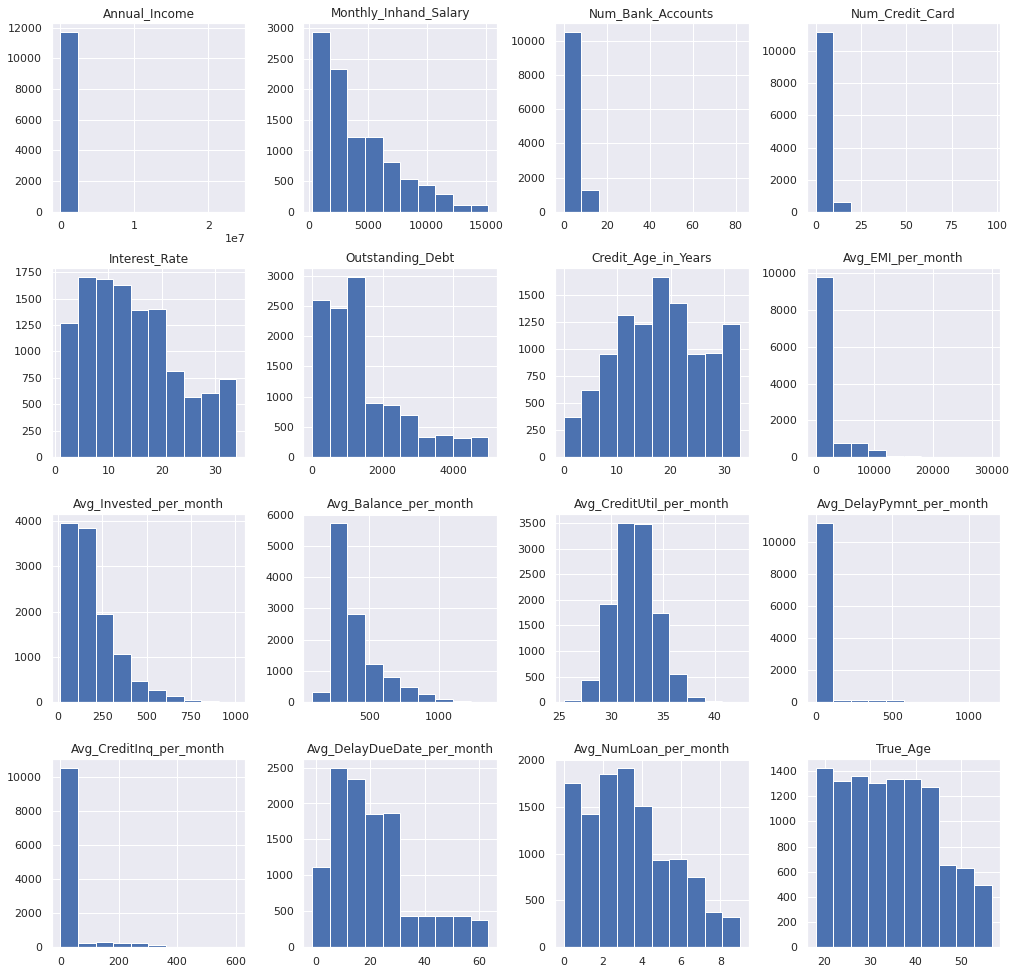

In [ ]:
credit_df_new.hist(figsize = (17,17));

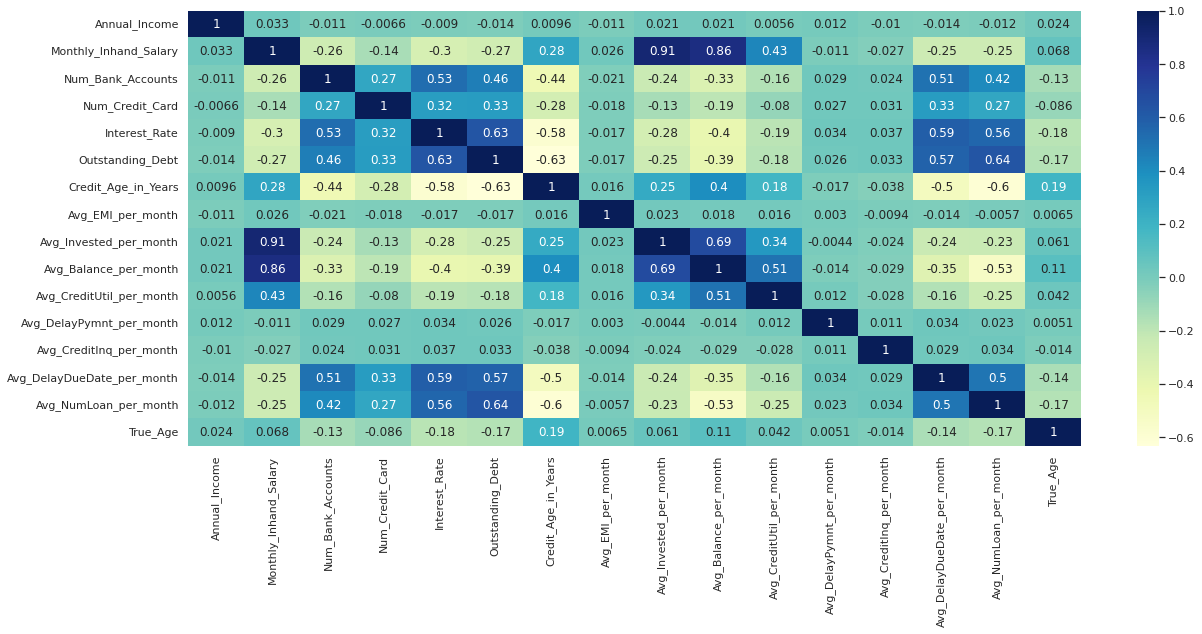

In [ ]:
# plot the heatmap and annotation on it
#Correlation matrix 
corr_matrix_credit = credit_df_new.corr()
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(corr_matrix_credit, cmap="YlGnBu", annot=True)
plt.show()

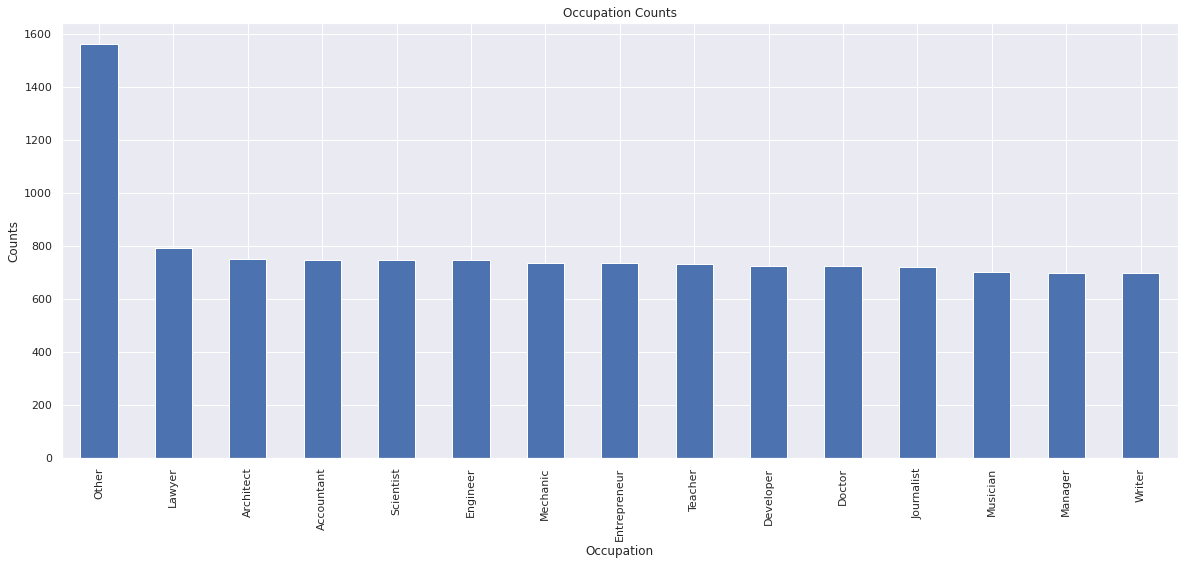

In [ ]:
credit_df_new['Occupation'].value_counts().plot(kind='bar')
plt.title('Occupation Counts')
plt.xlabel('Occupation')
plt.ylabel('Counts')
plt.show()

### Loan Type Feature Engineering

In [ ]:
#parse out the different loand types within the "Type_of_Loan" column
credit_df_new['Auto_Loan_Flag'] = credit_df_new['Type_of_Loan'].astype(str).map(lambda x: 1 if "Auto" in x else 0)
credit_df_new['Credit_Builder_Flag'] = credit_df_new['Type_of_Loan'].astype(str).map(lambda x: 1 if "Credit-Builder" in x else 0)
credit_df_new['Student_Loan_Flag'] = credit_df_new['Type_of_Loan'].astype(str).map(lambda x: 1 if "Student" in x else 0)
credit_df_new['Mortagage_Loan_Flag'] = credit_df_new['Type_of_Loan'].astype(str).map(lambda x: 1 if "Mortgage" in x else 0)
credit_df_new['Home_Equity_Flag'] = credit_df_new['Type_of_Loan'].astype(str).map(lambda x: 1 if "Home Equity" in x else 0)
credit_df_new['Debt_Consolidation_Flag'] = credit_df_new['Type_of_Loan'].astype(str).map(lambda x: 1 if "Debt Consolidation" in x else 0)
credit_df_new['PayDay_Flag'] = credit_df_new['Type_of_Loan'].astype(str).map(lambda x: 1 if "Payday" in x else 0)
credit_df_new['Personal_Loan_Flag'] = credit_df_new['Type_of_Loan'].astype(str).map(lambda x: 1 if "Personal" in x else 0)
#del credit_df_new['Type_of_Loan']
#credit_df_new.head(100)

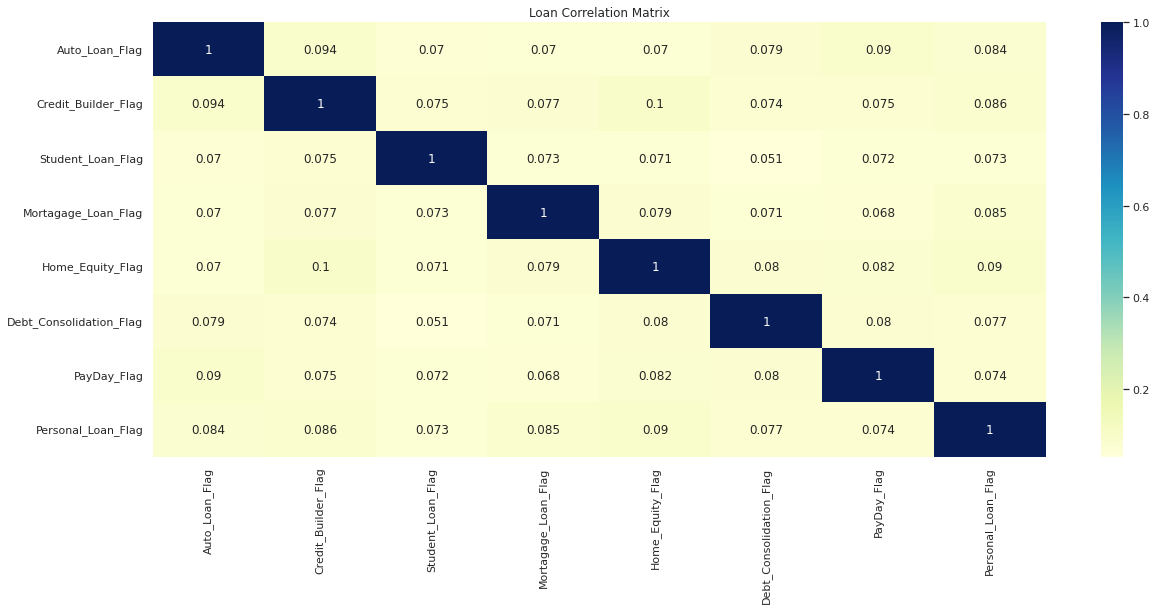

In [ ]:
#Correlation matrix for loan types only 
corr_matrix_credit = credit_df_new[['Auto_Loan_Flag','Credit_Builder_Flag','Student_Loan_Flag','Mortagage_Loan_Flag',
                                    'Home_Equity_Flag','Debt_Consolidation_Flag','PayDay_Flag','Personal_Loan_Flag']].corr()
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(corr_matrix_credit, cmap="YlGnBu", annot=True)
plt.title("Loan Correlation Matrix")
plt.show()

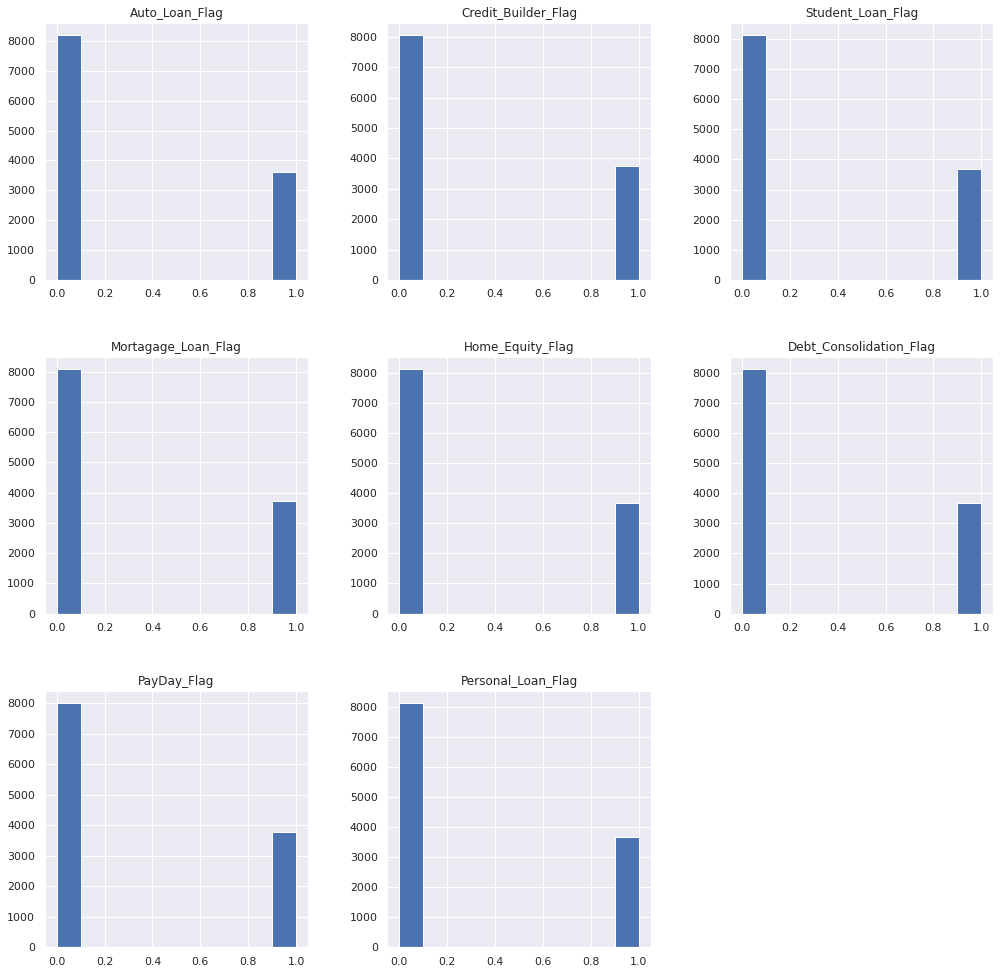

In [ ]:
#create an object of just the differnt types of loan values 
loan_values= credit_df_new[['Auto_Loan_Flag','Credit_Builder_Flag','Student_Loan_Flag','Mortagage_Loan_Flag',
                                    'Home_Equity_Flag','Debt_Consolidation_Flag','PayDay_Flag','Personal_Loan_Flag']]
#develop histogram of loan types                                  
loan_values.hist(figsize = (17,17));

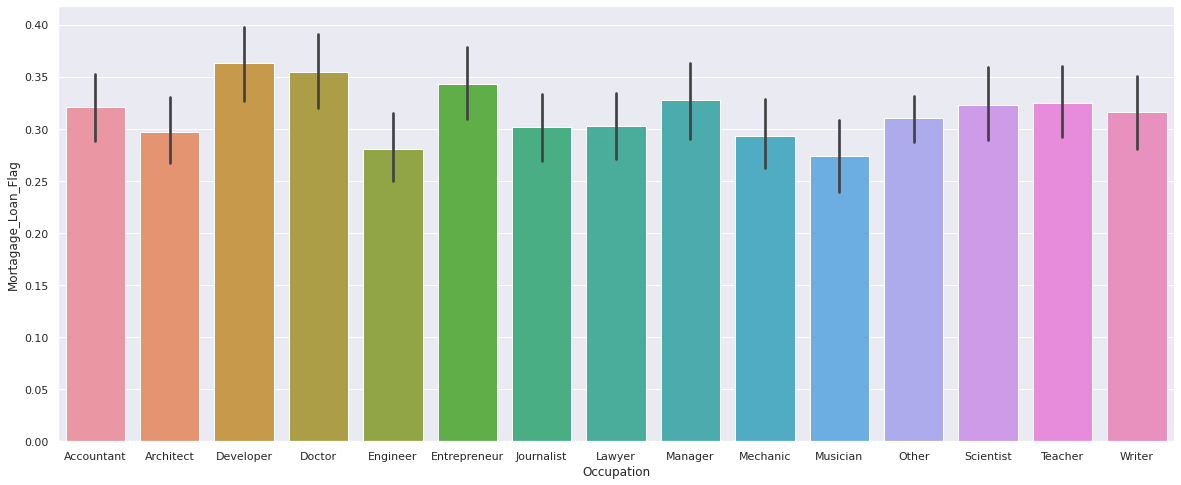

In [ ]:
#view the mortgage loan distribution by occupation
ax = sns.barplot(x="Occupation", y="Mortagage_Loan_Flag", data= credit_df_new)

### Binary output label

In [ ]:
#  Combine Poor and Standard categories:
# Different from numerical binary option
# Using 'Yes' to denote we should advertise
# to these clients:

pan = {'Poor' : 'No','Standard' : 'No', 
       'Good': 'Yes'}
credit_df_new['Credit_Ad'] = credit_df_new['Credit_Score'].map(pan)

In [ ]:
credit_df_new['Credit_Ad'].value_counts()
# no extreme imbalance at 20% minority class,
# But should still attempt using balanced classifiers

No     9534
Yes    2264
Name: Credit_Ad, dtype: int64

Look for any outliers/data that might not fit. Also, looking if any features that should be numerical, are not showing up due to dirty data:


In [ ]:
df_stat = credit_df_new.describe()
df_stat.loc['iqr'] = df_stat.apply(lambda x: x["75%"]-x["25%"])
#df_stat.loc['lowbound'] = df_stat.apply(lambda x: x["25%"]-x["iqr"]*1.5)
#df_stat.loc['upbound'] = df_stat.apply(lambda x: x["75%"]+x["iqr"]*1.5)
df_stat

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Outstanding_Debt,Credit_Age_in_Years,Avg_EMI_per_month,Avg_Invested_per_month,Avg_Balance_per_month,...,Avg_NumLoan_per_month,True_Age,Auto_Loan_Flag,Credit_Builder_Flag,Student_Loan_Flag,Mortagage_Loan_Flag,Home_Equity_Flag,Debt_Consolidation_Flag,PayDay_Flag,Personal_Loan_Flag
count,1.179800e+04,9988.000000,11798.000000,11798.000000,11798.000000,11798.000000,10741.000000,11798.000000,11798.000000,11798.000000,...,11798.000000,11149.000000,11798.000000,11798.000000,11798.000000,11798.000000,11798.000000,11798.000000,11798.000000,11798.000000
mean,1.611088e+05,4197.572662,5.396593,5.628920,14.555518,1429.086143,18.216926,1408.208501,195.878474,403.564746,...,3.384864,34.329462,0.306238,0.317766,0.311833,0.314969,0.312172,0.310561,0.320987,0.311070
std,1.288669e+06,3182.264794,2.863859,3.074303,8.749222,1158.394988,8.311759,2924.563370,136.859849,175.814977,...,2.360998,10.147193,0.460949,0.465628,0.463261,0.464523,0.463399,0.462743,0.466875,0.462951
min,7.005930e+03,303.645417,0.000000,0.000000,1.000000,0.230000,0.000000,0.000000,14.528879,92.841401,...,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.945599e+04,1623.766042,3.000000,4.000000,7.000000,565.032500,12.000000,41.165111,97.558584,284.555983,...,1.750000,25.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.772600e+04,3097.755000,5.500000,5.000000,13.000000,1167.065000,18.000000,105.465028,152.193782,339.311275,...,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.303090e+04,5981.070417,7.000000,7.000000,20.000000,1958.675000,25.000000,374.331962,258.352635,466.681112,...,5.000000,42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.383470e+07,15204.633333,82.000000,97.000000,34.000000,4998.070000,33.000000,29986.742104,1005.847285,1349.264887,...,9.000000,56.714286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
iqr,5.357491e+04,4357.304375,4.000000,3.000000,13.000000,1393.642500,13.000000,333.166851,160.794051,182.125130,...,3.250000,16.125000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
credit_df_new.isnull().sum()

ID                               0
Customer_ID                      0
Occupation                       0
Annual_Income                    0
Monthly_Inhand_Salary         1810
Num_Bank_Accounts                0
Num_Credit_Card                  0
Interest_Rate                    0
Type_of_Loan                  1344
Changed_Credit_Limit             0
Outstanding_Debt                 0
Credit_Score                     0
Credit_Age_in_Years           1057
Avg_EMI_per_month                0
Avg_Invested_per_month           0
Avg_Balance_per_month            0
Avg_CreditUtil_per_month         0
Avg_DelayPymnt_per_month         0
Avg_CreditInq_per_month          0
Avg_DelayDueDate_per_month       0
Avg_NumLoan_per_month            0
True_Age                       649
Mode_Payment_Min_Amount          0
Mode_Behavior_binary             0
Auto_Loan_Flag                   0
Credit_Builder_Flag              0
Student_Loan_Flag                0
Mortagage_Loan_Flag              0
Home_Equity_Flag    

In [ ]:
## Always an option to throw out nulls, but will attempt imputations
# after data split to avoid any test data information leakage
# hence corrupting our model by having been trained on data that has
# information (nearest neighbors or median/mean) from test data:

##credit_df_new = credit_df_new.dropna()

In [ ]:
credit_df_new['Mode_Behavior_binary']

7        High_Spend
15       High_Spend
23       High_Spend
31        Low_Spend
39       High_Spend
            ...    
99967    High_Spend
99975     Low_Spend
99983     Low_Spend
99991     Low_Spend
99999    High_Spend
Name: Mode_Behavior_binary, Length: 11798, dtype: object

In [ ]:
# Define categorical and numerical features:


categorical_features_credit = ['Occupation', 'Mode_Behavior_binary', 
                               'Mode_Payment_Min_Amount',
                               'Auto_Loan_Flag', 'Credit_Builder_Flag', 
                               'Student_Loan_Flag', 'Mortagage_Loan_Flag', 
                               'Home_Equity_Flag','Debt_Consolidation_Flag',
                               'PayDay_Flag', 'Personal_Loan_Flag']
numerical_features_credit = ['Annual_Income', 'Num_Bank_Accounts', 
                             'Num_Credit_Card', 'Interest_Rate',
                             'Outstanding_Debt', 'Credit_Age_in_Years',
                             'Avg_CreditInq_per_month', 
                             'Avg_EMI_per_month', 
                             'Avg_Invested_per_month', 'Avg_Balance_per_month',
                             'Avg_CreditUtil_per_month',
                             'True_Age', 'Monthly_Inhand_Salary']

# Generate dataframes with the different features

Xcat_credit_df = credit_df_new[categorical_features_credit]

Xnum_credit_df = credit_df_new[numerical_features_credit]

# Combine the two in order to maintain indices, used merge function
# although it should be automatic even with the join command, as
# both come from the same dataframe with no modifications.

# Create X and y for splitting and further pre-processing:

X_credit_df = pd.merge(Xcat_credit_df, Xnum_credit_df, left_index=True, 
                       right_index=True)

y_credit_df = credit_df_new[['Credit_Ad']]

In [ ]:
# Split data:
# Stratify tells us to randomly select samples for each train and test
# set while maintaining the proportions of Credit_Ad classes
# Since the original dataset contains about 20% yes and 80% No
# We should expect to see these same proportions in the ylabel for train
# and test:

X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit_df,
                                                                        y_credit_df,
                                                                        stratify = y_credit_df['Credit_Ad'],
                                                                test_size = 0.1,
                                                              random_state = 42)

In [ ]:
X_train_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10618 entries, 38775 to 38839
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Occupation                10618 non-null  category
 1   Mode_Behavior_binary      10618 non-null  object  
 2   Mode_Payment_Min_Amount   10618 non-null  category
 3   Auto_Loan_Flag            10618 non-null  int64   
 4   Credit_Builder_Flag       10618 non-null  int64   
 5   Student_Loan_Flag         10618 non-null  int64   
 6   Mortagage_Loan_Flag       10618 non-null  int64   
 7   Home_Equity_Flag          10618 non-null  int64   
 8   Debt_Consolidation_Flag   10618 non-null  int64   
 9   PayDay_Flag               10618 non-null  int64   
 10  Personal_Loan_Flag        10618 non-null  int64   
 11  Annual_Income             10618 non-null  float64 
 12  Num_Bank_Accounts         10618 non-null  int64   
 13  Num_Credit_Card           10618 non-null  

And indeed, we see the same yes and no class proportions in training and test y label sets:

In [ ]:
y_train_credit.value_counts()

Credit_Ad
No           8580
Yes          2038
dtype: int64

In [ ]:
y_test_credit.value_counts()

Credit_Ad
No           954
Yes          226
dtype: int64

In [ ]:
#manually check the distribution percentage of the training data
(2038/(2036+8580))*100

19.197437829691033

In [ ]:
#manually check the distribution percentage of the test data
(226/(226+954))*100

19.152542372881356

In [ ]:
##X_train_credit[numerical_features_credit].astype(float)
##X_test_credit[numerical_features_credit].astype(float)

X_train_credit.head()

,Occupation,Mode_Behavior_binary,Mode_Payment_Min_Amount,Auto_Loan_Flag,Credit_Builder_Flag,Student_Loan_Flag,Mortagage_Loan_Flag,Home_Equity_Flag,Debt_Consolidation_Flag,PayDay_Flag,...,Interest_Rate,Outstanding_Debt,Credit_Age_in_Years,Avg_CreditInq_per_month,Avg_EMI_per_month,Avg_Invested_per_month,Avg_Balance_per_month,Avg_CreditUtil_per_month,True_Age,Monthly_Inhand_Salary
38775,Developer,High_Spend,['No'],1,0,0,1,0,0,1,...,19,149.44,18.0,1.000000,7478.005877,305.868813,592.933017,35.196448,48.0,9694.486667
69079,Teacher,High_Spend,['No'],1,0,0,0,1,0,0,...,10,421.54,26.0,5.428571,59.372147,224.105713,555.486140,32.093604,31.4,5802.140000
90623,Accountant,High_Spend,['No'],1,0,0,0,0,1,0,...,12,1122.78,NaN,203.500000,3098.254403,318.026353,655.096569,34.082373,51.0,8438.955000
2975,Scientist,Low_Spend,['Yes'],1,0,0,0,1,0,1,...,18,516.76,18.0,7.375000,121.195063,154.242553,266.393760,29.460877,32.0,2031.587766
64191,Manager,Low_Spend,['No'],1,0,1,1,0,0,1,...,5,838.13,NaN,3.000000,38.533511,139.191457,261.306115,35.396913,31.0,1552.810833


In [ ]:
X_train_credit.isnull().sum()

Occupation                     0
Mode_Behavior_binary           0
Mode_Payment_Min_Amount        0
Auto_Loan_Flag                 0
Credit_Builder_Flag            0
Student_Loan_Flag              0
Mortagage_Loan_Flag            0
Home_Equity_Flag               0
Debt_Consolidation_Flag        0
PayDay_Flag                    0
Personal_Loan_Flag             0
Annual_Income                  0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Outstanding_Debt               0
Credit_Age_in_Years          954
Avg_CreditInq_per_month        0
Avg_EMI_per_month              0
Avg_Invested_per_month         0
Avg_Balance_per_month          0
Avg_CreditUtil_per_month       0
True_Age                     581
Monthly_Inhand_Salary       1653
dtype: int64

In [ ]:
X_train_credit.index

Int64Index([38775, 69079, 90623,  2975, 64191, 68943, 59863, 53039, 66727,
             6791,
            ...
            19983, 24439, 55799, 62215, 65703, 14071, 46055, 76943, 76791,
            38839],
           dtype='int64', length=10618)

### Imputation of training and test data
Done separately to avoid leakage
Using KNN to use nearest neighbors approach

In [ ]:
imputer = KNNImputer(n_neighbors=4)

X_train_credit_imp1 = imputer.fit_transform(X_train_credit[numerical_features_credit])

X_test_credit_imp1 = imputer.fit_transform(X_test_credit[numerical_features_credit])

X_train_credit_imp=pd.DataFrame(X_train_credit_imp1, columns = numerical_features_credit,
                                index = X_train_credit.index)

X_test_credit_imp=pd.DataFrame(X_test_credit_imp1, columns = numerical_features_credit,
                                index = X_test_credit.index)

X_train_credit_imp_df = pd.merge(X_train_credit[categorical_features_credit], 
                                 X_train_credit_imp, right_index=True,
                                 left_index=True)

X_test_credit_imp_df = pd.merge(X_test_credit[categorical_features_credit], 
                                 X_test_credit_imp, right_index=True,
                                 left_index=True)


In [ ]:
X_train_credit_imp_df.head(8)

,Occupation,Mode_Behavior_binary,Mode_Payment_Min_Amount,Auto_Loan_Flag,Credit_Builder_Flag,Student_Loan_Flag,Mortagage_Loan_Flag,Home_Equity_Flag,Debt_Consolidation_Flag,PayDay_Flag,...,Interest_Rate,Outstanding_Debt,Credit_Age_in_Years,Avg_CreditInq_per_month,Avg_EMI_per_month,Avg_Invested_per_month,Avg_Balance_per_month,Avg_CreditUtil_per_month,True_Age,Monthly_Inhand_Salary
38775,Developer,High_Spend,['No'],1,0,0,1,0,0,1,...,19.0,149.44,18.00,1.000000,7478.005877,305.868813,592.933017,35.196448,48.000000,9694.486667
69079,Teacher,High_Spend,['No'],1,0,0,0,1,0,0,...,10.0,421.54,26.00,5.428571,59.372147,224.105713,555.486140,32.093604,31.400000,5802.140000
90623,Accountant,High_Spend,['No'],1,0,0,0,0,1,0,...,12.0,1122.78,23.75,203.500000,3098.254403,318.026353,655.096569,34.082373,51.000000,8438.955000
2975,Scientist,Low_Spend,['Yes'],1,0,0,0,1,0,1,...,18.0,516.76,18.00,7.375000,121.195063,154.242553,266.393760,29.460877,32.000000,2031.587766
64191,Manager,Low_Spend,['No'],1,0,1,1,0,0,1,...,5.0,838.13,22.25,3.000000,38.533511,139.191457,261.306115,35.396913,31.000000,1552.810833
68943,Architect,High_Spend,['Yes'],0,0,0,0,0,1,0,...,5.0,277.38,17.00,4.000000,19.025280,86.796299,504.910421,35.504864,20.428571,3532.320000
59863,Manager,Low_Spend,['Yes'],0,0,1,0,0,1,1,...,12.0,893.87,14.00,9.875000,46.975654,78.325064,328.284865,30.873481,28.000000,1773.355833
53039,Developer,High_Spend,['No'],1,0,1,0,0,0,0,...,5.0,926.99,22.75,6.000000,4102.954208,149.681948,322.023180,32.239356,36.625000,2762.615833


In [ ]:
#check for NULL values after imputation
X_train_credit_imp_df.isnull().sum()

Occupation                  0
Mode_Behavior_binary        0
Mode_Payment_Min_Amount     0
Auto_Loan_Flag              0
Credit_Builder_Flag         0
Student_Loan_Flag           0
Mortagage_Loan_Flag         0
Home_Equity_Flag            0
Debt_Consolidation_Flag     0
PayDay_Flag                 0
Personal_Loan_Flag          0
Annual_Income               0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Outstanding_Debt            0
Credit_Age_in_Years         0
Avg_CreditInq_per_month     0
Avg_EMI_per_month           0
Avg_Invested_per_month      0
Avg_Balance_per_month       0
Avg_CreditUtil_per_month    0
True_Age                    0
Monthly_Inhand_Salary       0
dtype: int64

### Scale/Encode X data:

In [ ]:
# Pre-Process Training data categorical variables and 
# scale/normalize numericals by column

# (later will implement pipes to do this along with modeling)

X_train_credit_num = X_train_credit_imp_df[numerical_features_credit]
X_test_credit_num =  X_test_credit_imp_df[numerical_features_credit]

sc = preprocessing.StandardScaler()
sc_fitted = sc.fit(X_train_credit_num)

X_train_credit_sc = pd.DataFrame(sc_fitted.transform(X_train_credit_num), 
                               columns=X_train_credit_num.columns)
X_test_credit_sc = pd.DataFrame(sc_fitted.transform(X_test_credit_num), 
                              columns=X_test_credit_num.columns)

In [ ]:
X_train_credit_imp_df[categorical_features_credit].head()

,Occupation,Mode_Behavior_binary,Mode_Payment_Min_Amount,Auto_Loan_Flag,Credit_Builder_Flag,Student_Loan_Flag,Mortagage_Loan_Flag,Home_Equity_Flag,Debt_Consolidation_Flag,PayDay_Flag,Personal_Loan_Flag
38775,Developer,High_Spend,['No'],1,0,0,1,0,0,1,1
69079,Teacher,High_Spend,['No'],1,0,0,0,1,0,0,0
90623,Accountant,High_Spend,['No'],1,0,0,0,0,1,0,0
2975,Scientist,Low_Spend,['Yes'],1,0,0,0,1,0,1,0
64191,Manager,Low_Spend,['No'],1,0,1,1,0,0,1,0


In [ ]:
# Hot encode categorical features:
X_train_credit_cat = X_train_credit_imp_df[['Occupation']]
X_test_credit_cat =  X_test_credit_imp_df[['Occupation']]
#X_train_credit_cat=X_train_credit_cat.reshape(-1,1)
#X_test_credit_cat=X_test_credit_cat.reshape(-1,1)


##onehotencoder1 = OneHotEncoder(categorical_features = [0])
##cat_feat = onehotencoder1.fit(X_train_credit_imp_df).toarray()

#cat_feat = pd.DataFrame()
enc_hot = OneHotEncoder(categories = 'auto', sparse=False)
enc_ord = OrdinalEncoder()

cat_feat = enc_hot.fit(X_train_credit_cat)



X_train_credit_enc = pd.DataFrame(cat_feat.transform(X_train_credit_cat), 
                               columns=cat_feat.get_feature_names(['Occupation']))
X_test_credit_enc = pd.DataFrame(cat_feat.transform(X_test_credit_cat), 
                               columns=cat_feat.get_feature_names(['Occupation']))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#check the unique values from the Occupation attribute
X_train_credit_imp_df['Occupation'].unique()

['Developer', 'Teacher', 'Accountant', 'Scientist', 'Manager', ..., 'Musician', 'Journalist', 'Writer', 'Mechanic', 'Lawyer']
Length: 15
Categories (15, object): ['Accountant', 'Architect', 'Developer', 'Doctor', ..., 'Other', 'Scientist',
                          'Teacher', 'Writer']

In [ ]:
X_train_credit_enc.head()

,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Musician,Occupation_Other,Occupation_Scientist,Occupation_Teacher,Occupation_Writer
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Combine the two dataframes for scaled and encoded 
# numerical and categorical features:

X_train_credit_pre = pd.merge(X_train_credit_sc, X_train_credit_enc, left_index=True, 
                       right_index=True)

X_test_credit_pre = pd.merge(X_test_credit_sc, X_test_credit_enc, left_index=True, 
                       right_index=True)

# Encode multiclass output label:

#le = preprocessing.LabelEncoder()
#y_train_credit_enc = pd.DataFrame(le.fit(y_train_credit).transform(y_train_credit),
#                              columns = list(y_train_credit))


In [ ]:
#y_test_credit_enc = pd.DataFrame(le.fit(y_train_credit).transform(y_test_credit),
#                              columns = list(y_test_credit))

## Modeling

#### Balanced Perceptron model:

In [ ]:
balanced_model = make_pipeline(Perceptron(class_weight='balanced'))
unbalanced_model = make_pipeline(Perceptron())

In [ ]:
balanced_mod = balanced_model.fit(X_train_credit_pre, y_train_credit)
balanced_mod_pred_train = balanced_mod.predict(X_train_credit_pre)
balanced_mod_pred = balanced_mod.predict(X_test_credit_pre)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
cm_mod_train_bal = confusion_matrix(y_train_credit,
                      balanced_mod_pred_train)

cm_mod_test_bal = confusion_matrix(y_test_credit,
                      balanced_mod_pred)

In [ ]:
labels_mod = ['Yes', 'No']

train_results_bal = pd.DataFrame(cm_mod_train_bal, index = labels_mod, 
                                  columns = labels_mod)

test_results_bal = pd.DataFrame(cm_mod_test_bal, index = labels_mod, 
                                  columns = labels_mod)

In [ ]:
print('Train Data Confusion Matrix for Credit Data on Balanced Classifier')
print(train_results_bal)
print('\nTrain Accuracy for Credit Data on Balanced Classifier:\n')
print('\t\t\t\t', accuracy_score(y_train_credit, balanced_mod_pred_train))
print('\n')

print('Test Data Confusion Matrix for Credit Data on Balanced Classifier')
print(test_results_bal)
print('\nTest Accuracy for Credit data on Balanced Classifier:\n')
print('\t\t\t\t', accuracy_score(y_test_credit, balanced_mod_pred))
print('\n')

Train Data Confusion Matrix for Credit Data on Balanced Classifier
      Yes    No
Yes  5654  2926
No    586  1452

Train Accuracy for Credit Data on Balanced Classifier:

				 0.6692409116594462


Test Data Confusion Matrix for Credit Data on Balanced Classifier
     Yes   No
Yes  618  336
No    65  161

Test Accuracy for Credit data on Balanced Classifier:

				 0.6601694915254237




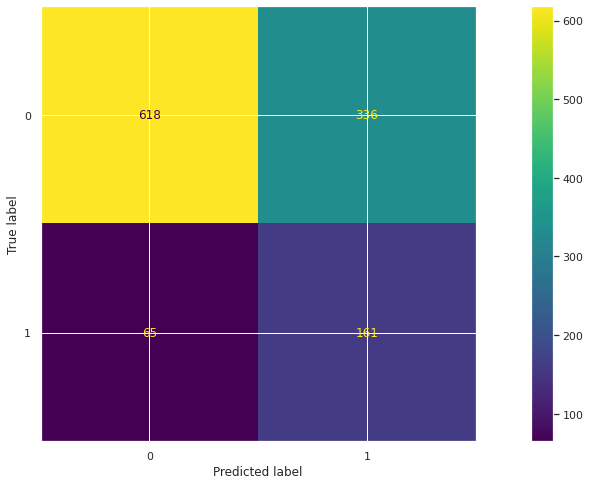

In [ ]:
#create a confusion matrix for display of the balanced perceptron 
confusion_matrix = metrics.confusion_matrix(y_test_credit,balanced_mod_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
print('\nClassification Report for Credit Data on Balanced Classifier:\n')
print(classification_report(y_test_credit, balanced_mod_pred))
print('\n')


Classification Report for Credit Data on Balanced Classifier:

              precision    recall  f1-score   support

          No       0.90      0.65      0.76       954
         Yes       0.32      0.71      0.45       226

    accuracy                           0.66      1180
   macro avg       0.61      0.68      0.60      1180
weighted avg       0.79      0.66      0.70      1180





#### Unbalanced Perceptron Model:

In [ ]:
unbalanced_mod = unbalanced_model.fit(X_train_credit_pre, y_train_credit)
unbalanced_mod_pred_train = unbalanced_mod.predict(X_train_credit_pre)
unbalanced_mod_pred = unbalanced_mod.predict(X_test_credit_pre)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
cm_mod_train_unbal = confusion_matrix(y_train_credit, unbalanced_mod_pred_train)

cm_mod_test_unbal = confusion_matrix(y_test_credit, unbalanced_mod_pred)

TypeError: ignored

In [ ]:
train_results_unbal = pd.DataFrame(cm_mod_train_unbal, index = labels_mod, 
                                  columns = labels_mod)

test_results_unbal = pd.DataFrame(cm_mod_test_unbal, index = labels_mod, 
                                  columns = labels_mod)

NameError: ignored

In [ ]:
print('Train Data Confusion Matrix for Credit Data on Unbalanced Classifier')
print(train_results_unbal)
print('\nTrain Accuracy for Credit Data on Unbalanced Classifier:\n')
print('\t\t\t\t', accuracy_score(y_train_credit, unbalanced_mod_pred_train))
print('\n')

print('Test Data Confusion Matrix for Credit Data on Unbalanced Classifier')
print(test_results_unbal)
print('\nTest Accuracy for Credit data on Unbalanced Classifier:\n')
print('\t\t\t\t', accuracy_score(y_test_credit, unbalanced_mod_pred))
print('\n')

Train Data Confusion Matrix for Credit Data on Unbalanced Classifier


NameError: ignored

In [ ]:
print('\nClassification Report for Credit Data on Unbalanced Classifier:\n')
print(classification_report(y_test_credit, unbalanced_mod_pred))
print('\n')


Classification Report for Credit Data on Unbalanced Classifier:

              precision    recall  f1-score   support

          No       0.84      0.91      0.87       954
         Yes       0.40      0.25      0.31       226

    accuracy                           0.79      1180
   macro avg       0.62      0.58      0.59      1180
weighted avg       0.75      0.79      0.77      1180





#### Random forest model:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initial model 
rf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 42)
rf_model = rf.fit(X_train_credit_pre, y_train_credit)
rf_train_pred = rf.predict(X_train_credit_pre)
rf_test_pred = rf.predict(X_test_credit_pre)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
cm_mod_train_rf = confusion_matrix(y_train_credit,
                      rf_train_pred)

cm_mod_test_rf = confusion_matrix(y_test_credit,
                      rf_test_pred)

TypeError: ignored

In [ ]:
train_results_rf = pd.DataFrame(cm_mod_train_rf, index = labels_mod, 
                                  columns = labels_mod)

test_results_rf = pd.DataFrame(cm_mod_test_rf, index = labels_mod, 
                                  columns = labels_mod)

NameError: ignored

In [ ]:
print('Train Data Confusion Matrix for Credit Data on RF Classifier')
print(train_results_rf)
print('\nTrain Accuracy for Credit Data on RF Classifier:\n')
print('\t\t\t\t', accuracy_score(y_train_credit, rf_train_pred))
print('\n')

print('Test Data Confusion Matrix for Credit Data on RF Classifier')
print(test_results_rf)
print('\nTest Accuracy for Credit data on RF Classifier:\n')
print('\t\t\t\t', accuracy_score(y_test_credit, rf_test_pred))
print('\n')

Train Data Confusion Matrix for Credit Data on RF Classifier


NameError: ignored

In [ ]:
print('\nClassification Report for Credit Data on RF Classifier:\n')
print(classification_report(y_test_credit, rf_test_pred))
print('\n')


Classification Report for Credit Data on RF Classifier:

              precision    recall  f1-score   support

          No       0.84      0.98      0.90       954
         Yes       0.71      0.19      0.29       226

    accuracy                           0.83      1180
   macro avg       0.77      0.58      0.60      1180
weighted avg       0.81      0.83      0.79      1180





#### Decision Tree Classifier

In [ ]:
#put the from at top of data
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier() 
clf_train = clf.fit(X_train_credit_pre, y_train_credit)  
y_pred_dt = clf_train.predict(X_test_credit_pre)
print('accuracy %2.2f ' % accuracy_score(y_test_credit,y_pred_dt))

accuracy 0.73 


In [ ]:
from sklearn.metrics import confusion_matrix
#cm_mod_train_dt = confusion_matrix(y_train_credit, clf_train)

cm_mod_test_dt = confusion_matrix(y_test_credit,y_pred_dt)

#labels_mod = ['Approve','Deny']

#train_results_lr = pd.DataFrame(cm_mod_train_lr, index = labels_mod, 
#                                columns = labels_mod)

test_results_dt = pd.DataFrame(cm_mod_test_dt, index = labels_mod, 
                                  columns = labels_mod)

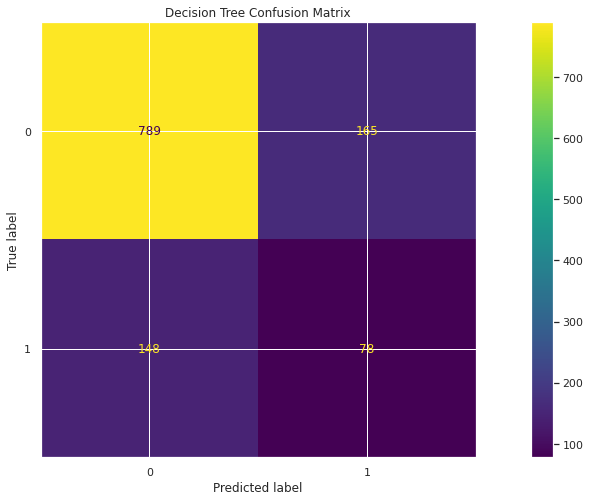

In [ ]:
#create a confusion matrix for display of the decision tree model 
confusion_matrix = metrics.confusion_matrix(y_test_credit,y_pred_dt)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [ ]:
#print('Train Data Confusion Matrix for Credit Data on Balanced Classifier')
#print(train_results_bal)
#print('\nTrain Accuracy for Credit Data on Balanced Classifier:\n')
#print('\t\t\t\t', accuracy_score(y_train_credit_enc, balanced_mod_pred_train))
#print('\n')

print('Test Data Confusion Matrix for Credit Data on Decision Tree Classifier')
print(test_results_dt)
print('\nTest Accuracy for Credit data on Decision Tree Classifier:\n')
print('\t\t\t\t', accuracy_score(y_test_credit, y_pred_dt))
print('\n')

Test Data Confusion Matrix for Credit Data on Decision Tree Classifier
     Yes   No
Yes  789  165
No   148   78

Test Accuracy for Credit data on Decision Tree Classifier:

				 0.7347457627118644




In [ ]:
print('\nClassification Report for Credit Data on Decision Tree Classifier:\n')
print(classification_report(y_test_credit, y_pred_dt))
print('\n')


Classification Report for Credit Data on Decision Tree Classifier:

              precision    recall  f1-score   support

          No       0.84      0.83      0.83       954
         Yes       0.32      0.35      0.33       226

    accuracy                           0.73      1180
   macro avg       0.58      0.59      0.58      1180
weighted avg       0.74      0.73      0.74      1180





#### KNN Model:

##### Euclidean Distance

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_values = range(1,20,2)
metric = "euclidean"
knn_accuracy = []
clfs =[]
classification_report = []

def k_neighbors(X_train_credit_pre, y_train_credit_enc, X_test_credit_pre, 
                y_test_credit_enc, kvalues, metric):
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric,p=2, n_neighbors=i).fit(X_train_credit_pre, 
                                                                     y_train_credit)
    clf_train_pred = clf.predict(X_train_credit_pre)
    clf_test_pred = clf.predict(X_test_credit_pre)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred, y_train_credit_enc),
    'Test Accuracy': accuracy_score(clf_test_pred, y_test_credit_enc)})

  return pd.DataFrame(knn_accuracy,clfs)

knn_df = k_neighbors(X_train_credit_pre, y_train_credit, X_test_credit_pre,
                     y_test_credit, k_values, metric)
knn_df

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

,k values,Training Accuracy,Test Accuracy
"KNeighborsClassifier(metric='euclidean', n_neighbors=1)",1,1.000000,0.726271
"KNeighborsClassifier(metric='euclidean', n_neighbors=3)",3,0.872104,0.755085
KNeighborsClassifier(metric='euclidean'),5,0.847429,0.771186
"KNeighborsClassifier(metric='euclidean', n_neighbors=7)",7,0.838859,0.782203
"KNeighborsClassifier(metric='euclidean', n_neighbors=9)",9,0.831230,0.787288
"KNeighborsClassifier(metric='euclidean', n_neighbors=11)",11,0.828028,0.784746
"KNeighborsClassifier(metric='euclidean', n_neighbors=13)",13,0.826521,0.789831
"KNeighborsClassifier(metric='euclidean', n_neighbors=15)",15,0.825297,0.801695
"KNeighborsClassifier(metric='euclidean', n_neighbors=17)",17,0.822565,0.800847
"KNeighborsClassifier(metric='euclidean', n_neighbors=19)",19,0.819646,0.802542


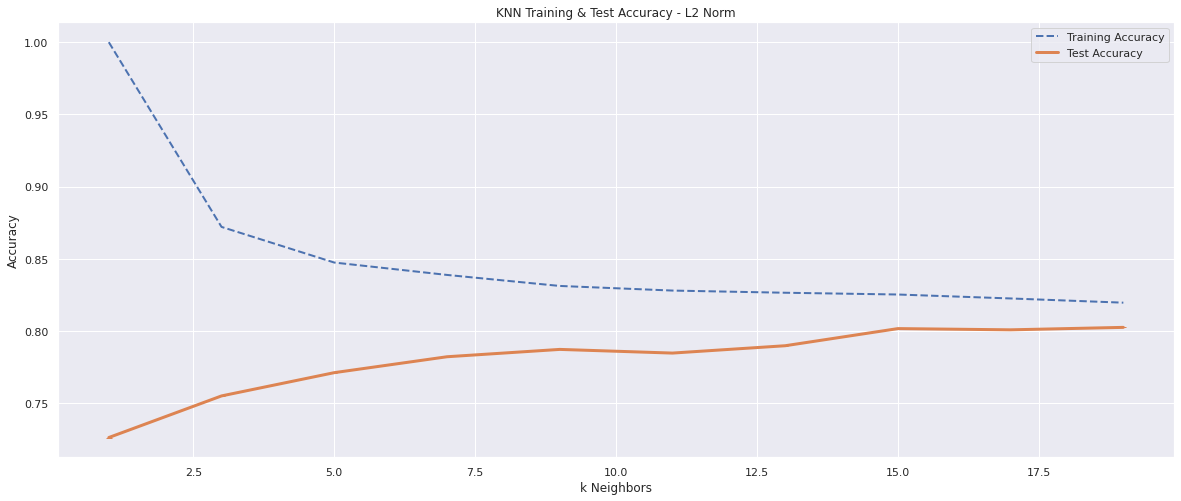

In [ ]:
plt.plot(knn_df['k values'], knn_df['Training Accuracy'], '--',linewidth=2, label='Training Accuracy')
plt.plot(knn_df['k values'], knn_df['Test Accuracy'], '-_',linewidth=3, label='Test Accuracy')
# Repeat the same plot as above but this time for test accutracy
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Training & Test Accuracy - L2 Norm')
plt.legend()
plt.show()

In [ ]:
#return the results of the most accurate KNN model - Euclidean
knn_accuracy = KNeighborsClassifier(metric=metric,p=2, n_neighbors=15).fit(X_train_credit_pre, 
                                                                     y_train_credit)
knn_train = knn_accuracy.fit(X_train_credit_pre, y_train_credit)  
y_pred_knn_euc = knn_train.predict(X_test_credit_pre)
print('accuracy %2.2f ' % accuracy_score(y_test_credit,y_pred_knn_euc))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


accuracy 0.80 


In [ ]:
#cm_mod_train_lr = confusion_matrix(y_train_credit_enc, clf_train)
cm_mod_test_knn = confusion_matrix(y_test_credit,y_pred_knn_euc)
labels_mod = ['Yes','No']
#train_results_lr = pd.DataFrame(cm_mod_train_lr, index = labels_mod, 
 #                                 columns = labels_mod)
test_results_knn = pd.DataFrame(cm_mod_test_knn, index = labels_mod, 
                                  columns = labels_mod)

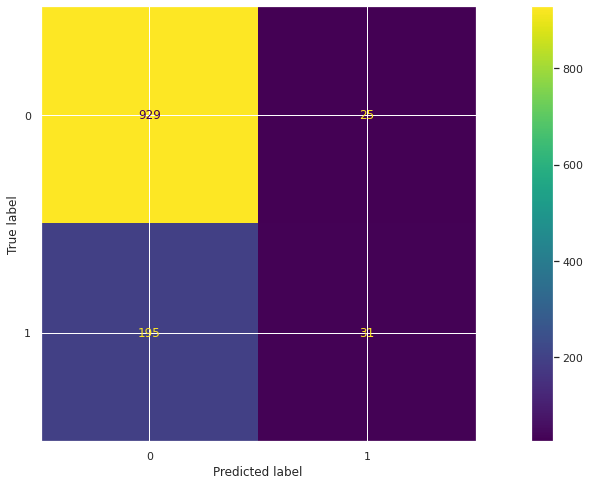

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test_credit,y_pred_knn)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
print('\nClassification Report for Credit Data on KNN - Euclidean Classifier:\n')
print(classification_report(y_test_credit, y_pred_knn_euc))
print('\n')


Classification Report for Credit Data on KNN - Euclidean Classifier:

              precision    recall  f1-score   support

          No       0.82      0.96      0.89       954
         Yes       0.46      0.13      0.20       226

    accuracy                           0.80      1180
   macro avg       0.64      0.55      0.54      1180
weighted avg       0.75      0.80      0.76      1180





##### Manhattan Distance

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_values = range(1,20,2)
metric = "manhattan"
knn_accuracy = []
clfs =[]

def k_neighbors(X_train_credit_pre, y_train_credit, X_test_credit_pre, 
                y_test_credit, kvalues, metric):
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric,p=2, n_neighbors=i).fit(X_train_credit_pre, 
                                                                     y_train_credit)
    clf_train_pred = clf.predict(X_train_credit_pre)
    clf_test_pred = clf.predict(X_test_credit_pre)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred, y_train_credit),
    'Test Accuracy': accuracy_score(clf_test_pred, y_test_credit)})
  return pd.DataFrame(knn_accuracy,clfs)

knn_df_man = k_neighbors(X_train_credit_pre, y_train_credit, X_test_credit_pre,
                     y_test_credit, k_values, metric)
knn_df_man

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

,k values,Training Accuracy,Test Accuracy
"KNeighborsClassifier(metric='manhattan', n_neighbors=1)",1,1.000000,0.737288
"KNeighborsClassifier(metric='manhattan', n_neighbors=3)",3,0.866642,0.770339
KNeighborsClassifier(metric='manhattan'),5,0.847429,0.781356
"KNeighborsClassifier(metric='manhattan', n_neighbors=7)",7,0.839706,0.779661
"KNeighborsClassifier(metric='manhattan', n_neighbors=9)",9,0.830382,0.800000
"KNeighborsClassifier(metric='manhattan', n_neighbors=11)",11,0.828970,0.800847
"KNeighborsClassifier(metric='manhattan', n_neighbors=13)",13,0.826333,0.805932
"KNeighborsClassifier(metric='manhattan', n_neighbors=15)",15,0.822942,0.804237
"KNeighborsClassifier(metric='manhattan', n_neighbors=17)",17,0.821529,0.813559
"KNeighborsClassifier(metric='manhattan', n_neighbors=19)",19,0.821718,0.811017


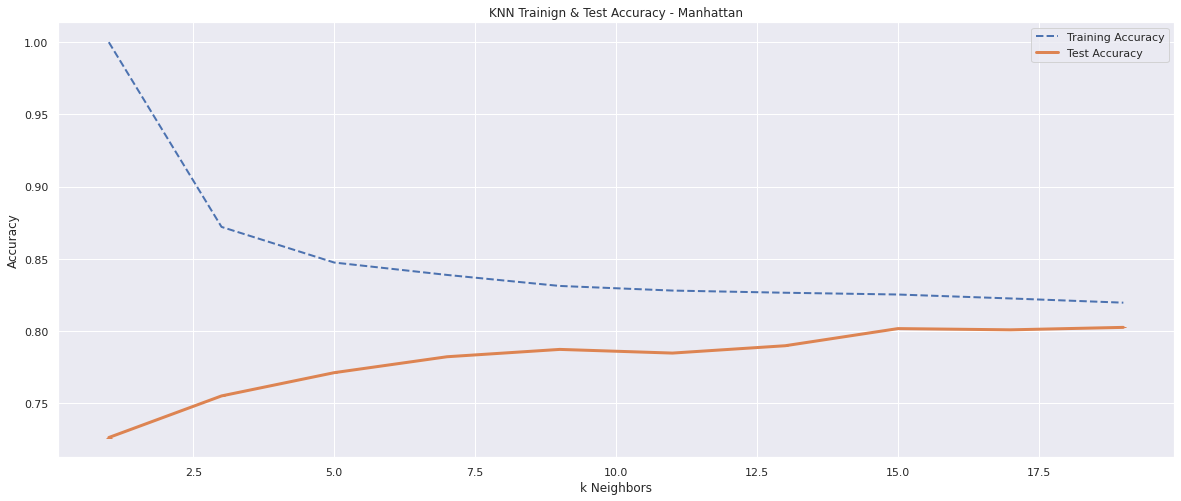

In [ ]:
plt.plot(knn_df_man['k values'], knn_df['Training Accuracy'], '--',linewidth=2, label='Training Accuracy')
plt.plot(knn_df_man['k values'], knn_df['Test Accuracy'], '-_',linewidth=3, label='Test Accuracy')
# Repeat the same plot as above but this time for test accutracy
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Trainign & Test Accuracy - Manhattan')
plt.legend()
plt.show()

In [ ]:
#return the results of the most accurate KNN model
knn_accuracy = KNeighborsClassifier(metric='manhattan',p=2, n_neighbors=17).fit(X_train_credit_pre, 
                                                                     y_train_credit)
knn_train = knn_accuracy.fit(X_train_credit_pre, y_train_credit)  
y_pred_knn_man = knn_train.predict(X_test_credit_pre)
print('accuracy %2.2f ' % accuracy_score(y_test_credit,y_pred_knn_man))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


accuracy 0.81 


In [ ]:
#cm_mod_train_lr = confusion_matrix(y_train_credit_enc, clf_train)
cm_mod_test_knn_man = confusion_matrix(y_test_credit,y_pred_knn_man)
labels_mod = ['Yes','No']
#train_results_lr = pd.DataFrame(cm_mod_train_lr, index = labels_mod, 
 #                                 columns = labels_mod)
test_results_knn_man = pd.DataFrame(cm_mod_test_knn_man, index = labels_mod, 
                                  columns = labels_mod)

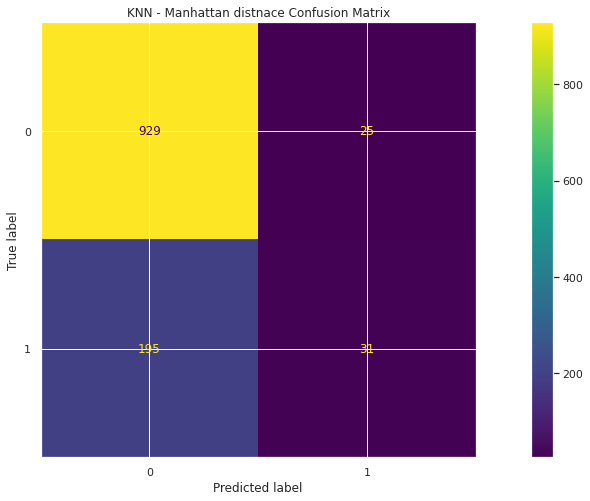

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test_credit,y_pred_knn_man)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title("KNN - Manhattan distnace Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
print('\nClassification Report for Credit Data on KNN - Manhattan Classifier:\n')
print(classification_report(y_test_credit, y_pred_knn_man))
print('\n')


Classification Report for Credit Data on KNN - Manhattan Classifier:

              precision    recall  f1-score   support

          No       0.83      0.97      0.89       954
         Yes       0.55      0.14      0.22       226

    accuracy                           0.81      1180
   macro avg       0.69      0.56      0.56      1180
weighted avg       0.77      0.81      0.76      1180





#### SGGClassifier Model

In [ ]:
#loop to create the model 
from sklearn.linear_model import SGDClassifier

loss_f = ['log', 'hinge', 'perceptron']
scores_list = []
avg_list = []

for i, loss in enumerate(loss_f):
  models = SGDClassifier(loss = loss).fit(X_train_credit_pre,y_train_credit)
  cv = cross_val_score(models, X_train_credit_pre, y_train_credit, cv=5, scoring='accuracy')
  scores_list.append({'Model': models, 'cv': cv})
  avg_list.append({'Model': models, 'Avg CrossVal': cv.mean()})

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
pd.DataFrame(avg_list)

,Model,Avg CrossVal
0,SGDClassifier(loss='log'),0.803635
1,SGDClassifier(),0.804200
2,SGDClassifier(loss='perceptron'),0.710775


In [ ]:
from sklearn.linear_model import SGDClassifier

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []
for a in alphas:
  l1clf = SGDClassifier(loss ='log', penalty= 'l1', alpha = a).fit(X_train_credit_pre,y_train_credit)
  print('Finished training, alpha=%f' % a)
  l1cv = cross_val_score(l1clf, X_train_credit_pre, y_train_credit, scoring = 'accuracy', cv = 5, n_jobs=5)
  #Create cross_val_score with l1clf for Xtrain and  ytrain with cv=5 'accuracy' as scoring='accuracy' it is good to define n_jobs to make it faster and compute the mean at the end
  print('Finished 5-fold CV, alpha=%f' % a)
  results.append({'alpha': a, 'log L1': l1cv.mean()})
  results # append 'alpha' and 'log L1'
l1_acc = pd.DataFrame(results)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished training, alpha=0.000010
Finished 5-fold CV, alpha=0.000010
Finished training, alpha=0.000100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished 5-fold CV, alpha=0.000100
Finished training, alpha=0.001000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished 5-fold CV, alpha=0.001000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished training, alpha=0.010000
Finished 5-fold CV, alpha=0.010000
Finished training, alpha=0.100000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished 5-fold CV, alpha=0.100000
Finished training, alpha=1.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished 5-fold CV, alpha=1.000000
Finished training, alpha=10.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished 5-fold CV, alpha=10.000000
Finished training, alpha=100.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished 5-fold CV, alpha=100.000000
Finished training, alpha=1000.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished 5-fold CV, alpha=1000.000000


In [ ]:
l1_acc

,alpha,log L1
0,0.00001,0.806179
1,0.00010,0.802223
2,0.00100,0.809004
3,0.01000,0.809192
4,0.10000,0.808062
5,1.00000,0.808062
6,10.00000,0.808062
7,100.00000,0.808062
8,1000.00000,0.561430


In [ ]:
#use the best Stochastic Gradient Descent classifier to build specific model
sgcd = SGDClassifier(loss ='log', penalty= 'l1', alpha = 0.001).fit(X_train_credit_pre,y_train_credit)
sgcd_pred = sgcd.predict(X_test_credit_pre)
print('accuracy %2.2f ' % accuracy_score(y_test_credit,sgcd_pred))

accuracy 0.82 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
cm_mod_test_sgcd = confusion_matrix(y_test_credit, sgcd_pred)

test_results_sgcd = pd.DataFrame(cm_mod_test_sgcd, index = labels_mod, 
                                  columns = labels_mod)

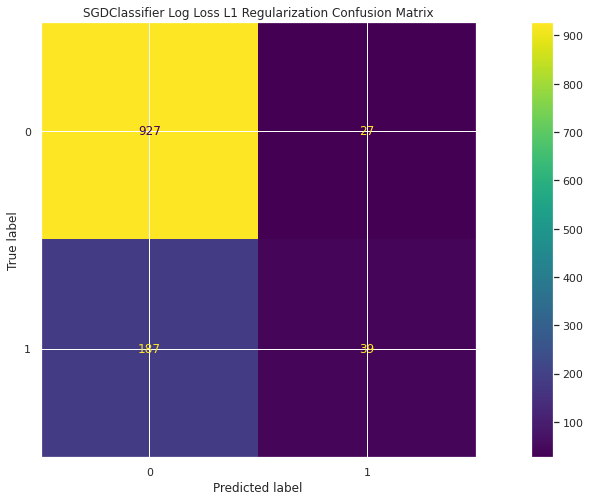

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test_credit,sgcd_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title("SGDClassifier Log Loss L1 Regularization Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
print('\nClassification Report for Credit Data on SGDClassifier - Log Loss - L1:\n')
print(classification_report(y_test_credit, sgcd_pred))
print('\n')


Classification Report for Credit Data on SGDClassifier - Log Loss - L1:

              precision    recall  f1-score   support

          No       0.83      0.97      0.90       954
         Yes       0.59      0.17      0.27       226

    accuracy                           0.82      1180
   macro avg       0.71      0.57      0.58      1180
weighted avg       0.79      0.82      0.78      1180





### Performance Metrics and Modeling Results

In [ ]:
print('\nClassification Report for Credit Data on Balanced Classifier:\n')
print(classification_report(y_test_credit, balanced_mod_pred))
print('\n')


Classification Report for Credit Data on Balanced Classifier:

              precision    recall  f1-score   support

          No       0.90      0.65      0.76       954
         Yes       0.32      0.71      0.45       226

    accuracy                           0.66      1180
   macro avg       0.61      0.68      0.60      1180
weighted avg       0.79      0.66      0.70      1180





In [ ]:
print('\nClassification Report for Credit Data on Unbalanced Classifier:\n')
print(classification_report(y_test_credit, unbalanced_mod_pred))
print('\n')


Classification Report for Credit Data on Unbalanced Classifier:

              precision    recall  f1-score   support

          No       0.84      0.91      0.87       954
         Yes       0.40      0.25      0.31       226

    accuracy                           0.79      1180
   macro avg       0.62      0.58      0.59      1180
weighted avg       0.75      0.79      0.77      1180





In [ ]:
print('\nClassification Report for Credit Data on RF Classifier:\n')
print(classification_report(y_test_credit, rf_test_pred))
print('\n')


Classification Report for Credit Data on RF Classifier:

              precision    recall  f1-score   support

          No       0.84      0.98      0.90       954
         Yes       0.71      0.19      0.29       226

    accuracy                           0.83      1180
   macro avg       0.77      0.58      0.60      1180
weighted avg       0.81      0.83      0.79      1180





In [ ]:
print('\nClassification Report for Credit Data on Decision Tree Classifier:\n')
print(classification_report(y_test_credit, y_pred_dt))
print('\n')


Classification Report for Credit Data on Decision Tree Classifier:

              precision    recall  f1-score   support

          No       0.84      0.83      0.83       954
         Yes       0.32      0.35      0.33       226

    accuracy                           0.73      1180
   macro avg       0.58      0.59      0.58      1180
weighted avg       0.74      0.73      0.74      1180





In [ ]:
print('\nClassification Report for Credit Data on KNN - Euclidean Classifier:\n')
print(classification_report(y_test_credit, y_pred_knn_euc))
print('\n')


Classification Report for Credit Data on KNN - Euclidean Classifier:

              precision    recall  f1-score   support

          No       0.82      0.96      0.89       954
         Yes       0.46      0.13      0.20       226

    accuracy                           0.80      1180
   macro avg       0.64      0.55      0.54      1180
weighted avg       0.75      0.80      0.76      1180





In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
print('\nClassification Report for Credit Data on KNN - Manhattan Classifier:\n')
print(classification_report(y_test_credit, y_pred_knn_man))
print('\n')


Classification Report for Credit Data on KNN - Manhattan Classifier:

              precision    recall  f1-score   support

          No       0.83      0.97      0.89       954
         Yes       0.55      0.14      0.22       226

    accuracy                           0.81      1180
   macro avg       0.69      0.56      0.56      1180
weighted avg       0.77      0.81      0.76      1180





In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
print('\nClassification Report for Credit Data on SGDClassifier - Log Loss - L1:\n')
print(classification_report(y_test_credit, sgcd_pred))
print('\n')


Classification Report for Credit Data on SGDClassifier - Log Loss - L1:

              precision    recall  f1-score   support

          No       0.83      0.97      0.90       954
         Yes       0.59      0.17      0.27       226

    accuracy                           0.82      1180
   macro avg       0.71      0.57      0.58      1180
weighted avg       0.79      0.82      0.78      1180





We want to maximize precision of "Yes", however, want to do so by limiting the amount of false positives - as we do not want to tell people they are pre-approved and then have them denied. 
